In [1]:
import h5py, os, random, gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.models as Model
from tensorflow.keras.layers import Input, Reshape, BatchNormalization, Conv2D, Dropout, Flatten, Dense, Activation, MaxPooling2D, AlphaDropout
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

In [2]:
f = h5py.File('ExtractDataset/part0.h5')
sample_num = f['X'].shape[0]
idx = np.random.choice(range(sample_num), size=sample_num)
# idx = np.random.choice(range(0,sample_num), size=1000)
X = f['X'][:][idx]
Y = f['Y'][:][idx]
Z = f['Z'][:][idx]
f.close()

for i in range(1,24):
    filename = 'ExtractDataset/part'+str(i) + '.h5'
    f = h5py.File(filename,'r')
    X = np.vstack((X,f['X'][:][idx]))
    Y = np.vstack((Y,f['Y'][:][idx]))
    Z = np.vstack((Z,f['Z'][:][idx]))
    gc.collect()
    f.close()


print('X-size：',X.shape)
print('Y-size：',Y.shape)
print('Z-size：',Z.shape)

X-size： (748800, 1024, 2)
Y-size： (748800, 24)
Z-size： (748800, 1)


In [3]:
n_examples = X.shape[0]
# n_train = int(n_examples * 0.9877)
n_train = int(n_examples * 0.9)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)  #Randomly select training sample subscript
test_idx = list(set(range(0,n_examples))-set(train_idx)) #Test sample index
X_train = X[train_idx]  #training samples
X_test =  X[test_idx]  #testing samples
Y_train = Y[train_idx]
Y_test = Y[test_idx]
Z_train = Z[train_idx]
Z_test = Z[test_idx]
print("X_train:",X_train.shape)
print("Y_train:",Y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",Y_test.shape)

X_train: (673920, 1024, 2)
Y_train: (673920, 24)
X_test: (74880, 1024, 2)
Y_test: (74880, 24)


In [4]:
classes = ['32PSK',
 '16APSK',
 '32QAM',
 'FM',
 'GMSK',
 '32APSK',
 'OQPSK',
 '8ASK',
 'BPSK',
 '8PSK',
 'AM-SSB-SC',
 '4ASK',
 '16PSK',
 '64APSK',
 '128QAM',
 '128APSK',
 'AM-DSB-SC',
 'AM-SSB-WC',
 '64QAM',
 'QPSK',
 '256QAM',
 'AM-DSB-WC',
 'OOK',
 '16QAM']

def residual_stack(X,Filters,Seq):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer='glorot_uniform',data_format="channels_first")(X)
    X = BatchNormalization(axis = 3)(X)

    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    
    return X

def resnet_model(X_train,classes):
    in_shp = X_train.shape[1:]   #Dimensions of each sample
    #input layer
    X_input = Input(in_shp)
    X = Reshape([1,1024,2], input_shape=in_shp)(X_input)
    #Residual Srack 1
    X = residual_stack(X,32,"ReStk1")  #shape:(1,512,32)
    X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    #Residual Srack 2
    X = residual_stack(X,32,"ReStk2")  #shape:(1,256,32)
    #Residual Srack 3
    X = residual_stack(X,32,"ReStk3")  #shape:(1,128,32)
    #Residual Srack 4
    X = residual_stack(X,32,"ReStk4")  #shape:(1,64,32)
    #Residual Srack 5
    X = residual_stack(X,32,"ReStk5")  #shape:(1,32,32)
    # #Residual Srack 6
    X = residual_stack(X,32,"ReStk6")  #shape:(1,16,32)
    #Full Con 1
    X = Flatten()(X)
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense1")(X)
    X = Dropout(0.3)(X)
    #Full Con 2
    X = Dense(128, activation='selu', kernel_initializer='he_normal', name="dense2")(X)
    X = Dropout(0.3)(X)
    #Full Con 3
    X = Dense(len(classes), kernel_initializer='he_normal', name="dense3")(X)
    #SoftMax
    X = Activation('softmax')(X)
    #Create Model
    return tf.keras.models.Model(inputs=X_input,outputs=X)

model = resnet_model(X_train,classes)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 2)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 1024, 2)   0           ['input_1[0][0]']                
                                                                                                  
 ReStk1_conv1 (Conv2D)          (None, 32, 1024, 2)  64          ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 1024, 2)  8          ['ReStk1_conv1[0][0]']           
 alization)                                                                                   

In [5]:
gc.collect()
filepath = 'resnet_model.keras'
history = model.fit(X_train,
    Y_train,
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_split = 0.1,
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

Epoch 1/100
593/593 [==============================] - ETA: 0s - loss: 2.5262 - accuracy: 0.1691
Epoch 1: val_loss improved from inf to 2.42067, saving model to resnet_model.keras
593/593 [==============================] - 368s 480ms/step - loss: 2.5262 - accuracy: 0.1691 - val_loss: 2.4207 - val_accuracy: 0.1955
Epoch 2/100
593/593 [==============================] - ETA: 0s - loss: 2.0208 - accuracy: 0.2866
Epoch 2: val_loss improved from 2.42067 to 2.06487, saving model to resnet_model.keras
593/593 [==============================] - 238s 402ms/step - loss: 2.0208 - accuracy: 0.2866 - val_loss: 2.0649 - val_accuracy: 0.2853
Epoch 3/100
593/593 [==============================] - ETA: 0s - loss: 1.9028 - accuracy: 0.3323
Epoch 3: val_loss improved from 2.06487 to 1.91399, saving model to resnet_model.keras
593/593 [==============================] - 239s 402ms/step - loss: 1.9028 - accuracy: 0.3323 - val_loss: 1.9140 - val_accuracy: 0.3326
Epoch 4/100
593/593 [==========================

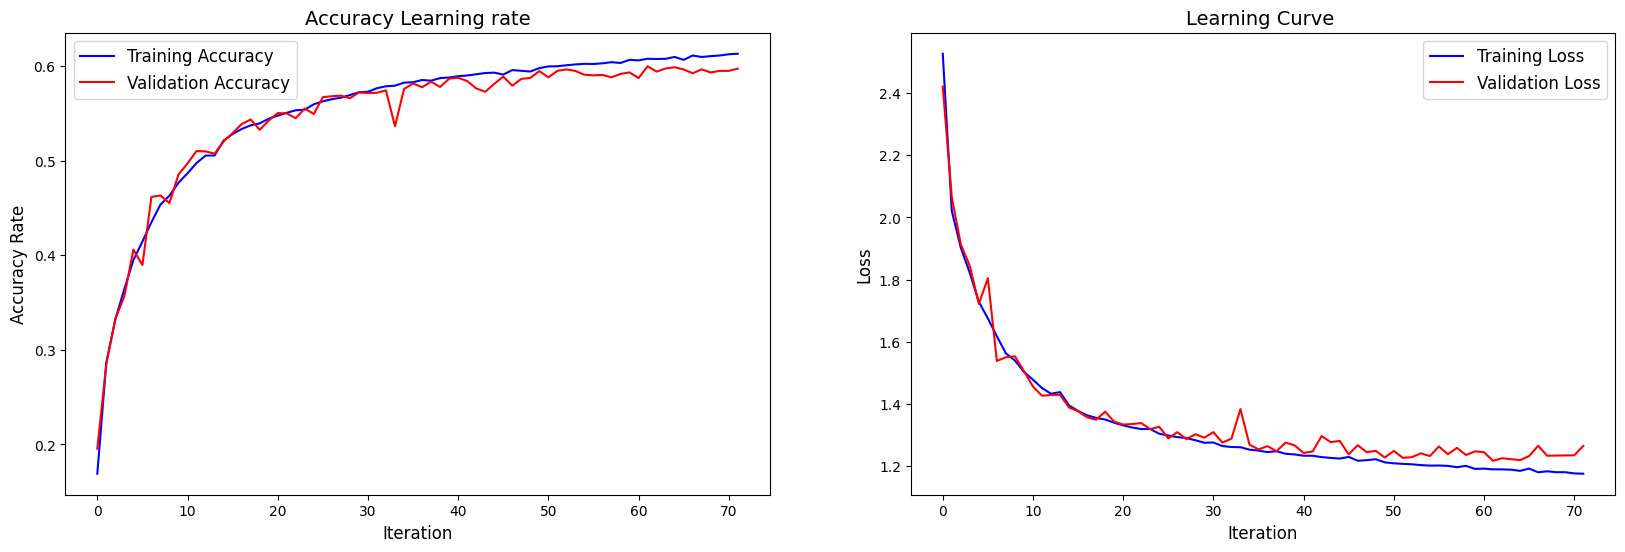

In [6]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
ax1.set_ylabel('Accuracy Rate',fontsize=12)
ax1.set_xlabel('Iteration',fontsize=12)
ax1.set_title('Accuracy Learning rate',fontsize=14)
ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
ax2.set_ylabel('Loss',fontsize=12)
ax2.set_xlabel('Iteration',fontsize=12)
ax2.set_title('Learning Curve ',fontsize=14)
ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

plt.show()

74/74 [==============================] - 8s 108ms/step


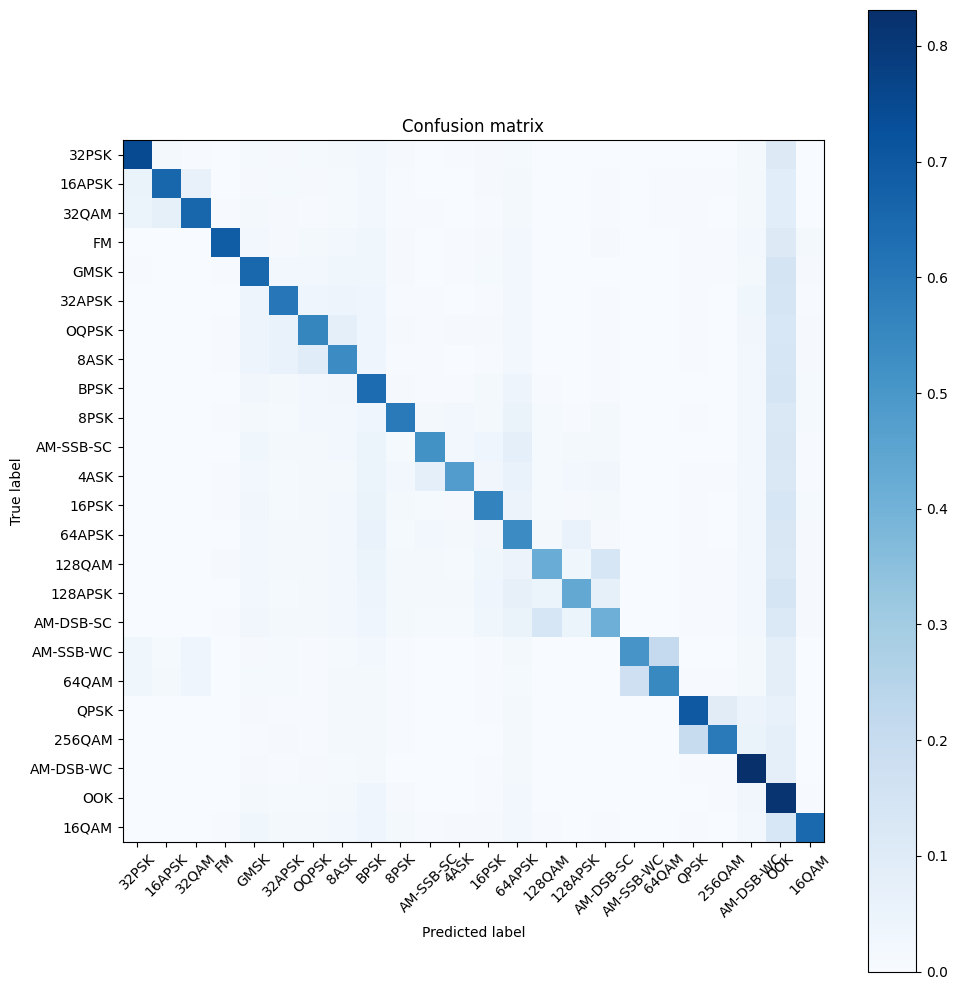

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [8]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

32PSK 0.7436548223350253
16APSK 0.6576886940181648
32QAM 0.6563719115734721
FM 0.6881889763779527
GMSK 0.6543408360128617
32APSK 0.6036703155183516
OQPSK 0.5561257216164208
8ASK 0.537270087124879
BPSK 0.6382371591629676
8PSK 0.5913978494623656
AM-SSB-SC 0.5191062176165803
4ASK 0.4774213640610402
16PSK 0.5640204865556978
64APSK 0.5360993139496897
128QAM 0.4201005025125628
128APSK 0.4380348652931854
AM-DSB-SC 0.4118956743002545
AM-SSB-WC 0.5062721132196848
64QAM 0.545844327176781
QPSK 0.7005758157389635
256QAM 0.5909237206308336
AM-DSB-WC 0.8310916484203941
OOK 0.8143322475570033
16QAM 0.6471529110684581


88/88 [==============================] - 1s 6ms/step
Overall Accuracy -20:  0.04789135096497498
95/95 [==============================] - 1s 5ms/step
Overall Accuracy -18:  0.04667328699106256
85/85 [==============================] - 0s 5ms/step
Overall Accuracy -16:  0.04963235294117647
89/89 [==============================] - 0s 5ms/step
Overall Accuracy -14:  0.0431247790738777
92/92 [==============================] - 1s 6ms/step
Overall Accuracy -12:  0.06429548563611491
91/91 [==============================] - 1s 6ms/step
Overall Accuracy -10:  0.10415950498453076
91/91 [==============================] - 1s 5ms/step
Overall Accuracy -8:  0.16545265348595214
93/93 [==============================] - 0s 4ms/step
Overall Accuracy -6:  0.21275873769935527
90/90 [==============================] - 0s 4ms/step
Overall Accuracy -4:  0.3044545773412838
91/91 [==============================] - 1s 6ms/step
Overall Accuracy -2:  0.4195105136159945
90/90 [==============================] - 1s 6ms

C:\Users\SomeUnknown\AppData\Local\Temp\ipykernel_13216\925050271.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


90/90 [==============================] - 0s 5ms/step
Overall Accuracy 2:  0.644109396914446
93/93 [==============================] - 0s 5ms/step
Overall Accuracy 4:  0.7288768238887003
88/88 [==============================] - 0s 5ms/step
Overall Accuracy 6:  0.8366834170854272
91/91 [==============================] - 1s 6ms/step
Overall Accuracy 8:  0.9082758620689655
92/92 [==============================] - 0s 5ms/step
Overall Accuracy 10:  0.9313993174061433
97/97 [==============================] - 0s 5ms/step
Overall Accuracy 12:  0.9409857328145266
90/90 [==============================] - 0s 5ms/step
Overall Accuracy 14:  0.9464847848898216
92/92 [==============================] - 1s 5ms/step
Overall Accuracy 16:  0.9441589585474478
91/91 [==============================] - 0s 5ms/step
Overall Accuracy 18:  0.9526443138610439
87/87 [==============================] - 0s 6ms/step
Overall Accuracy 20:  0.949244060475162
92/92 [==============================] - 1s 6ms/step
Overall Accur

<Figure size 640x480 with 0 Axes>

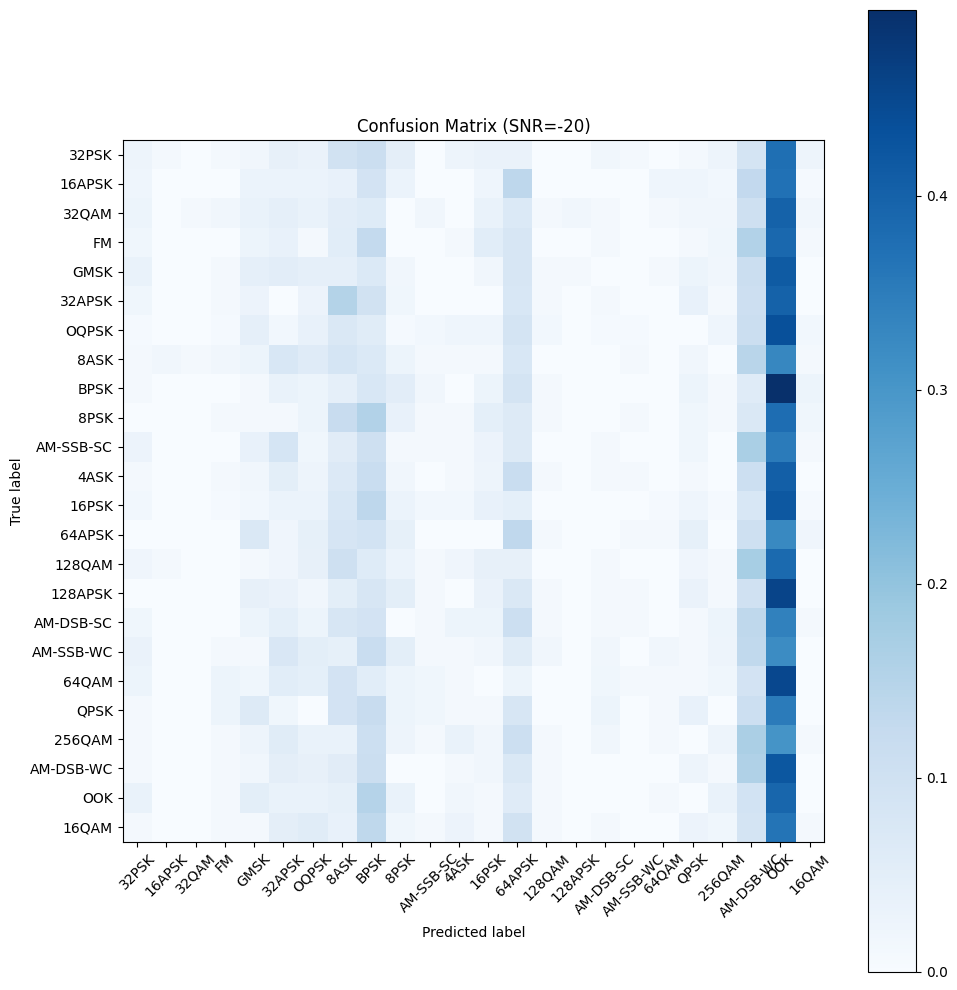

<Figure size 640x480 with 0 Axes>

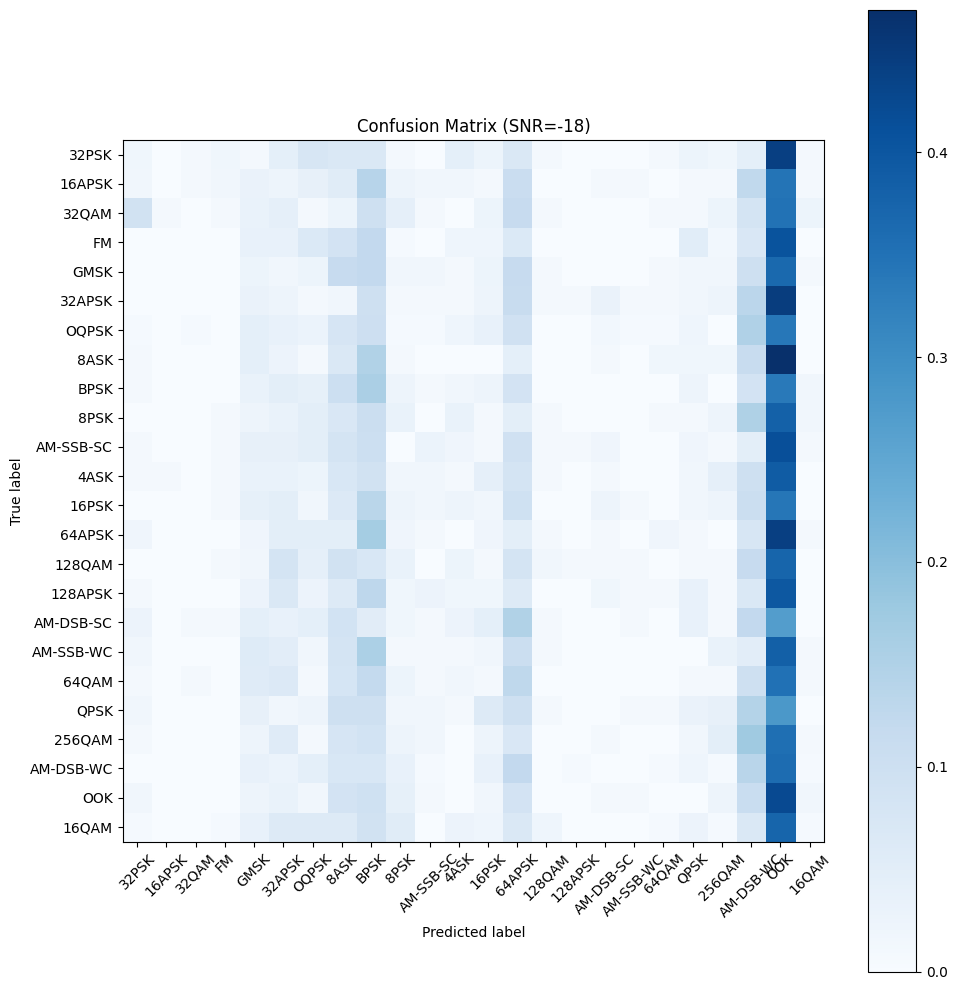

<Figure size 640x480 with 0 Axes>

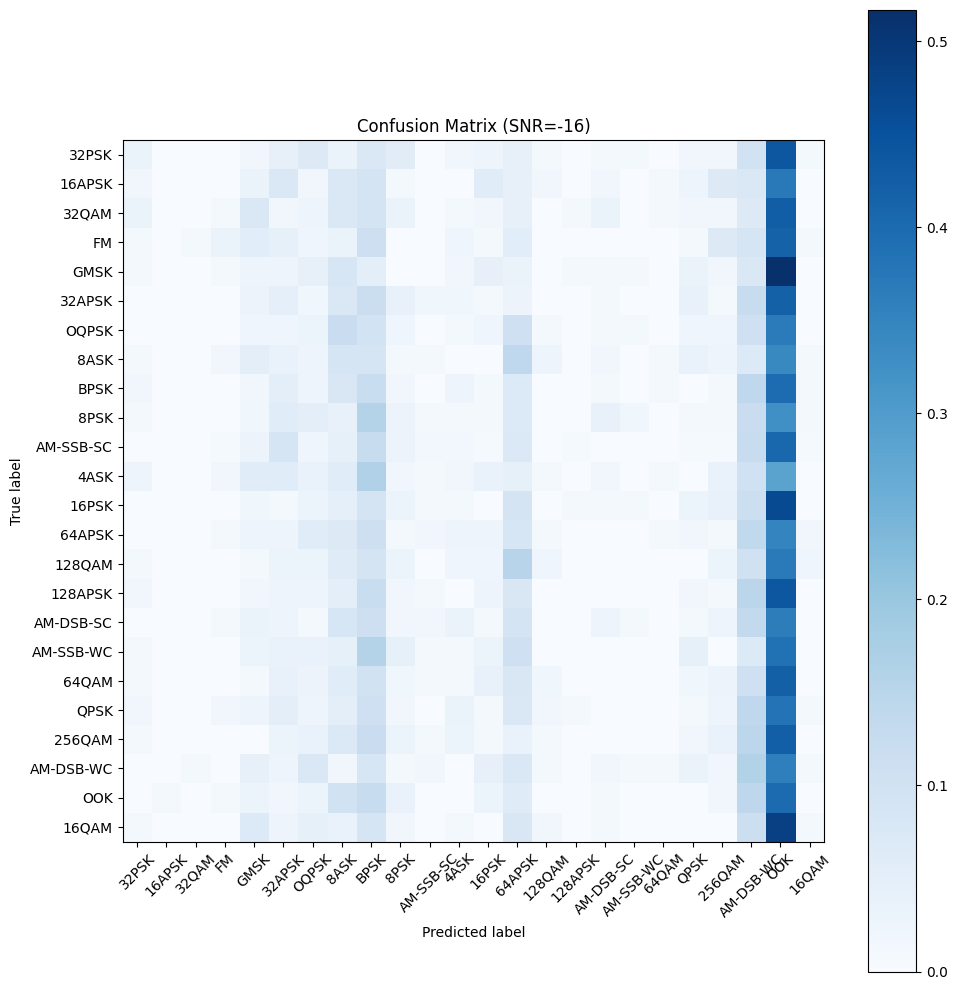

<Figure size 640x480 with 0 Axes>

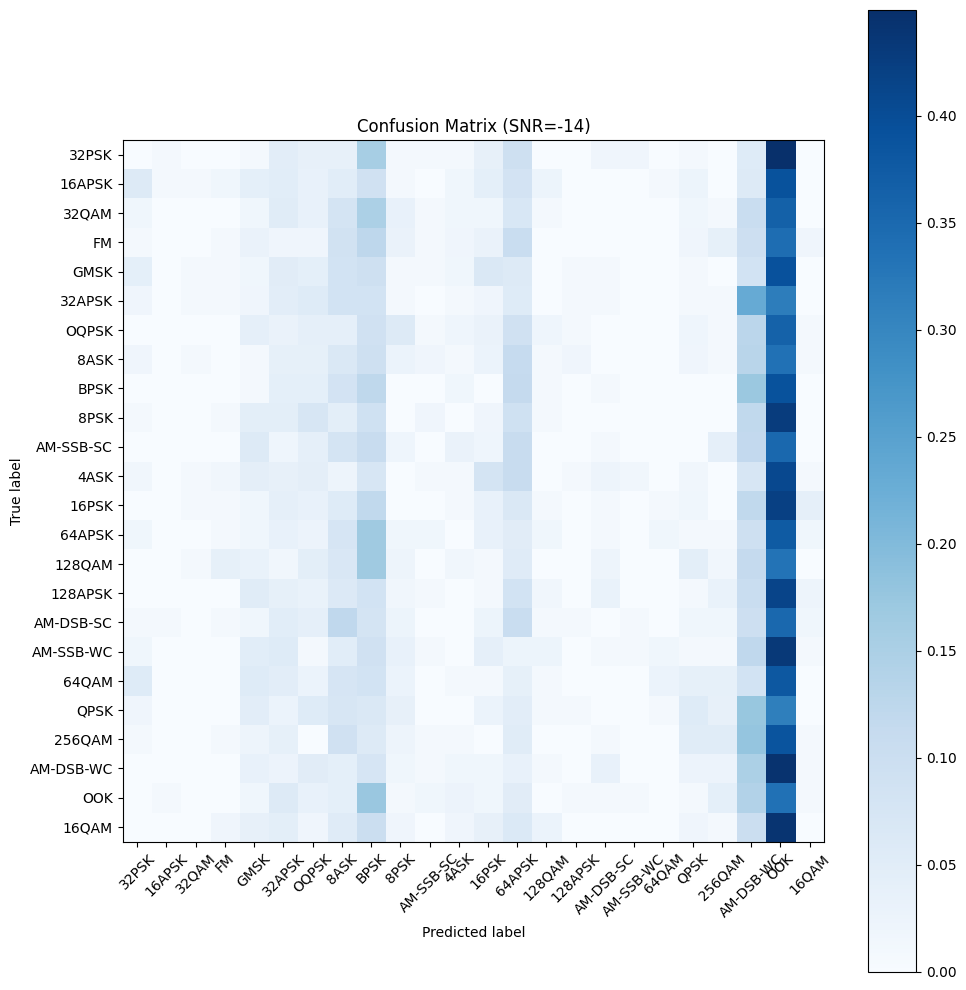

<Figure size 640x480 with 0 Axes>

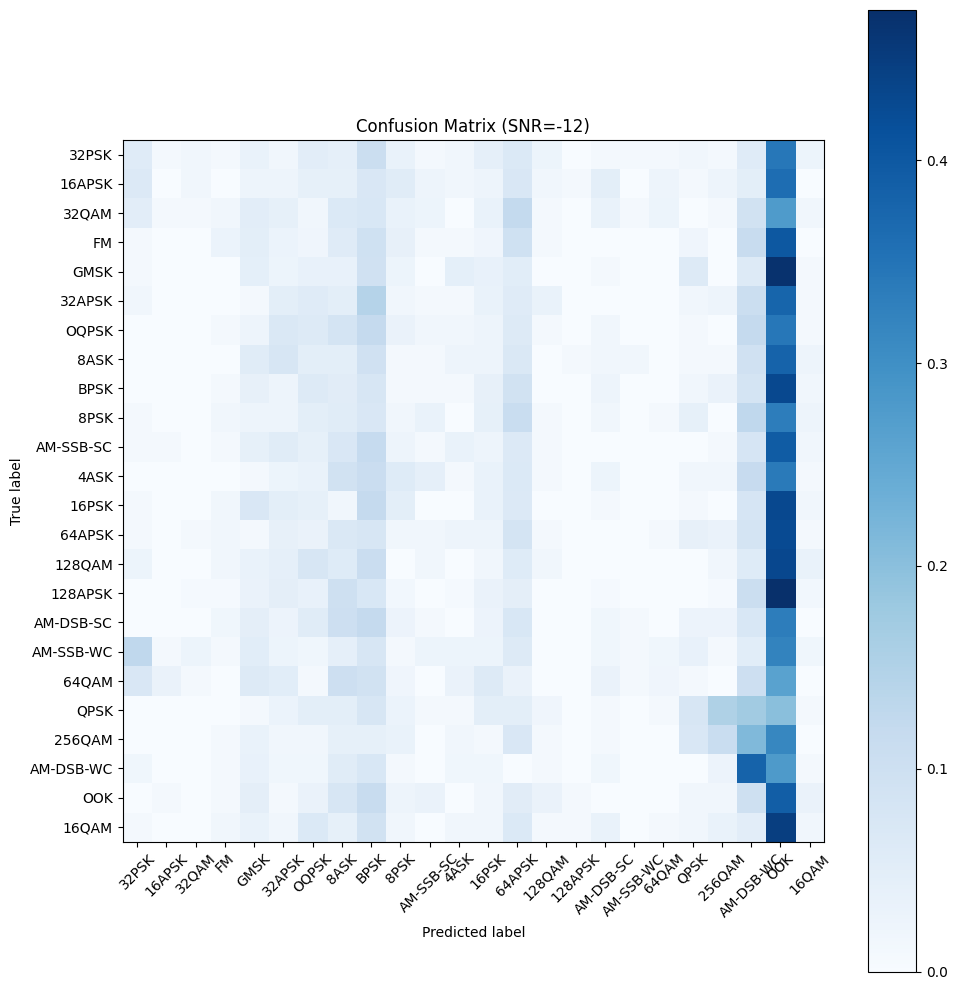

<Figure size 640x480 with 0 Axes>

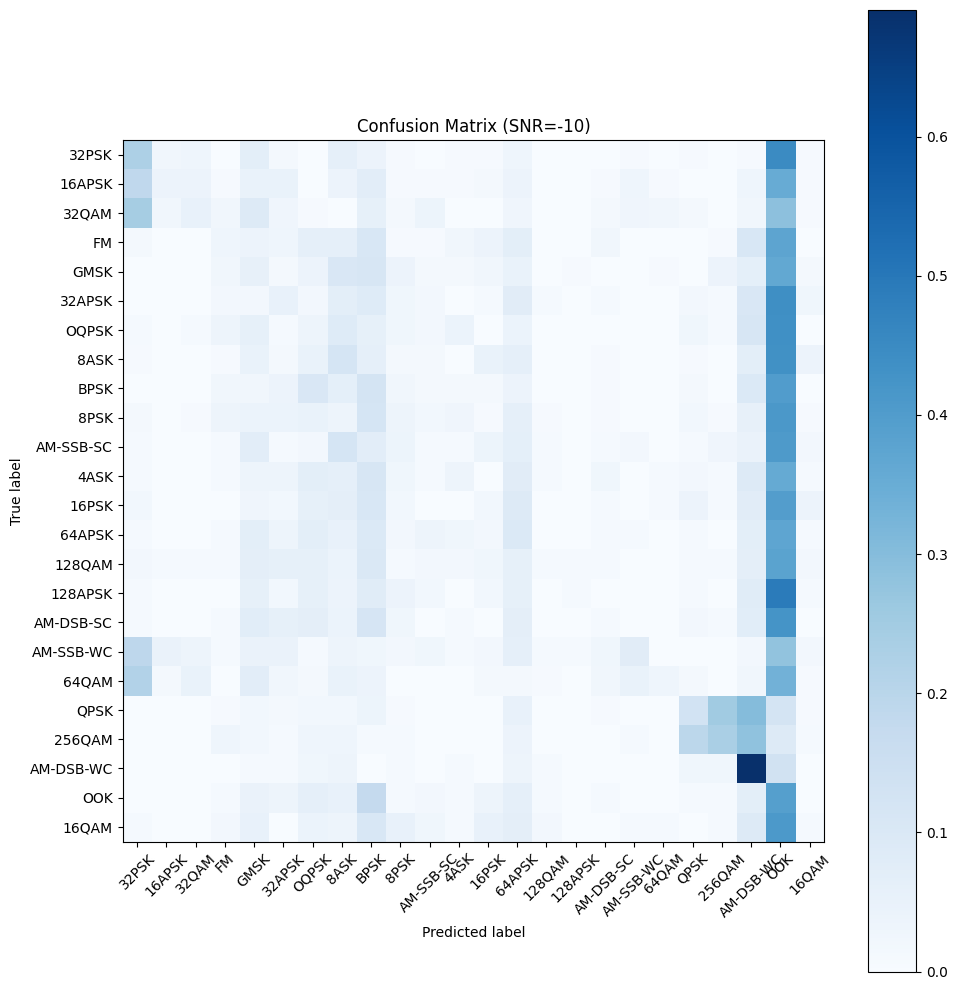

<Figure size 640x480 with 0 Axes>

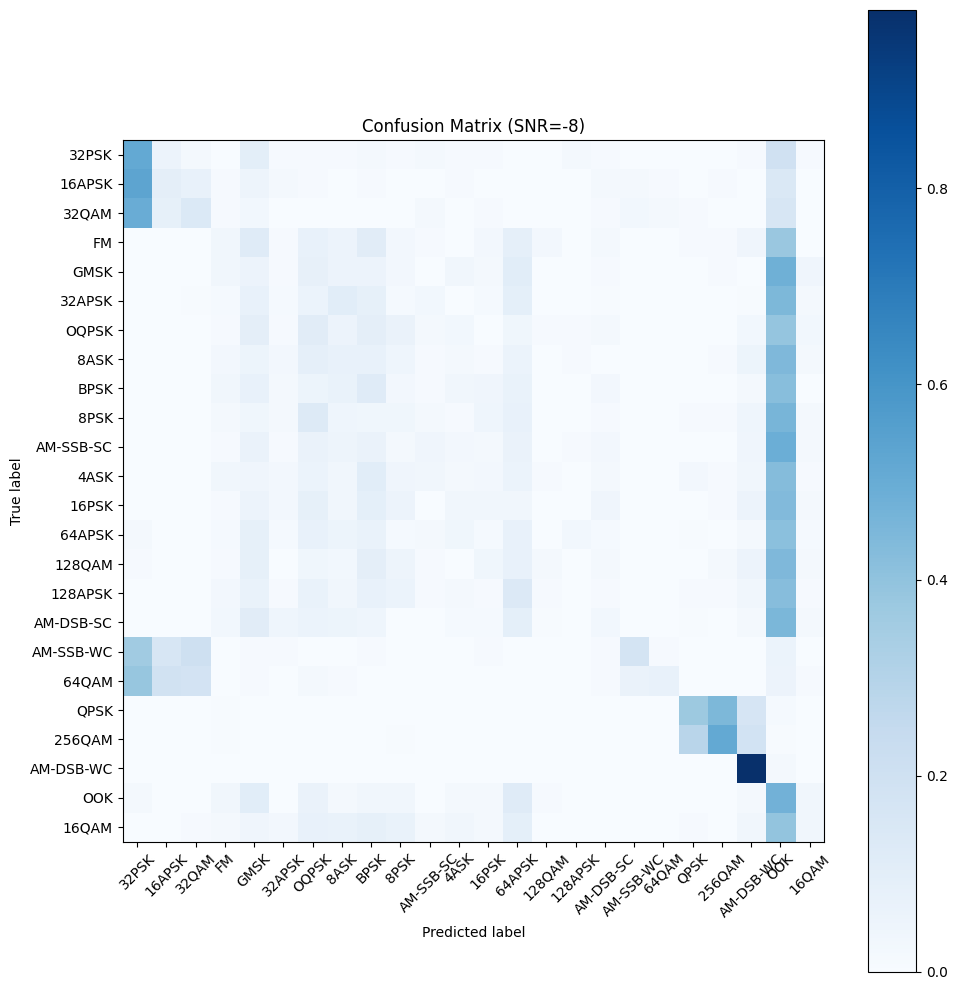

<Figure size 640x480 with 0 Axes>

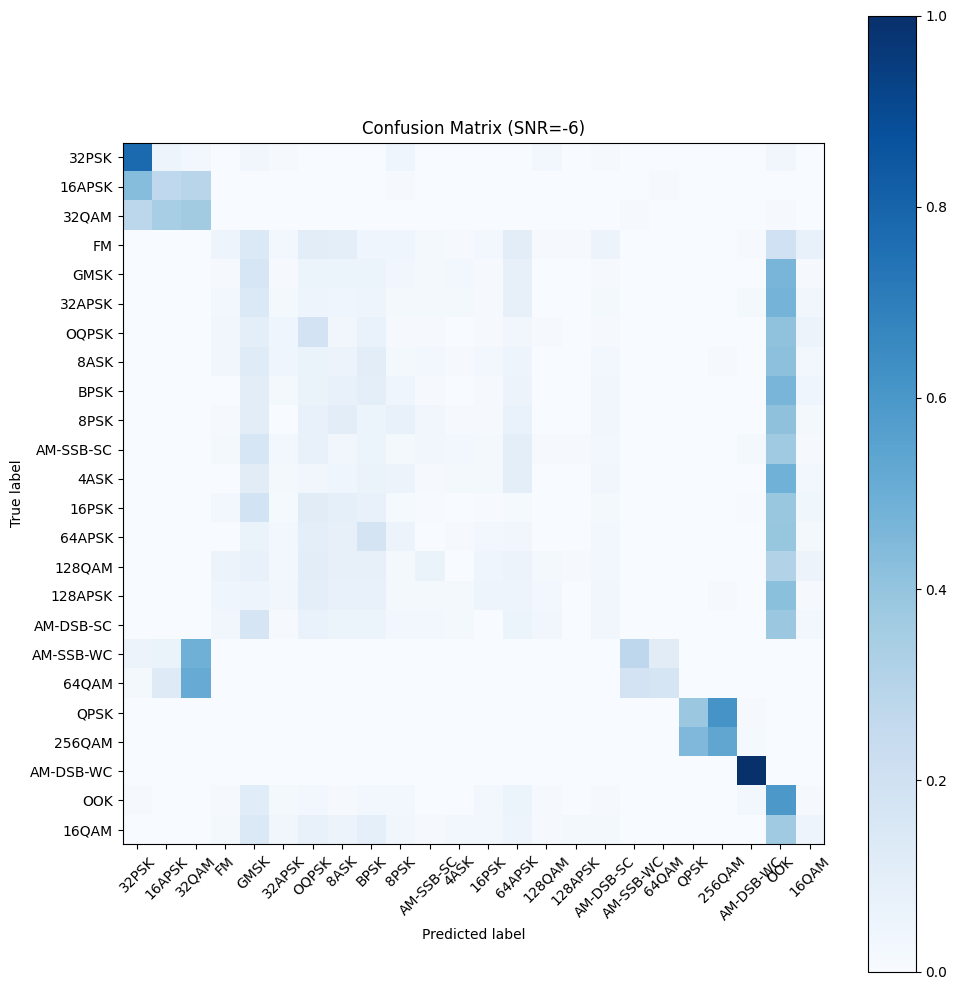

<Figure size 640x480 with 0 Axes>

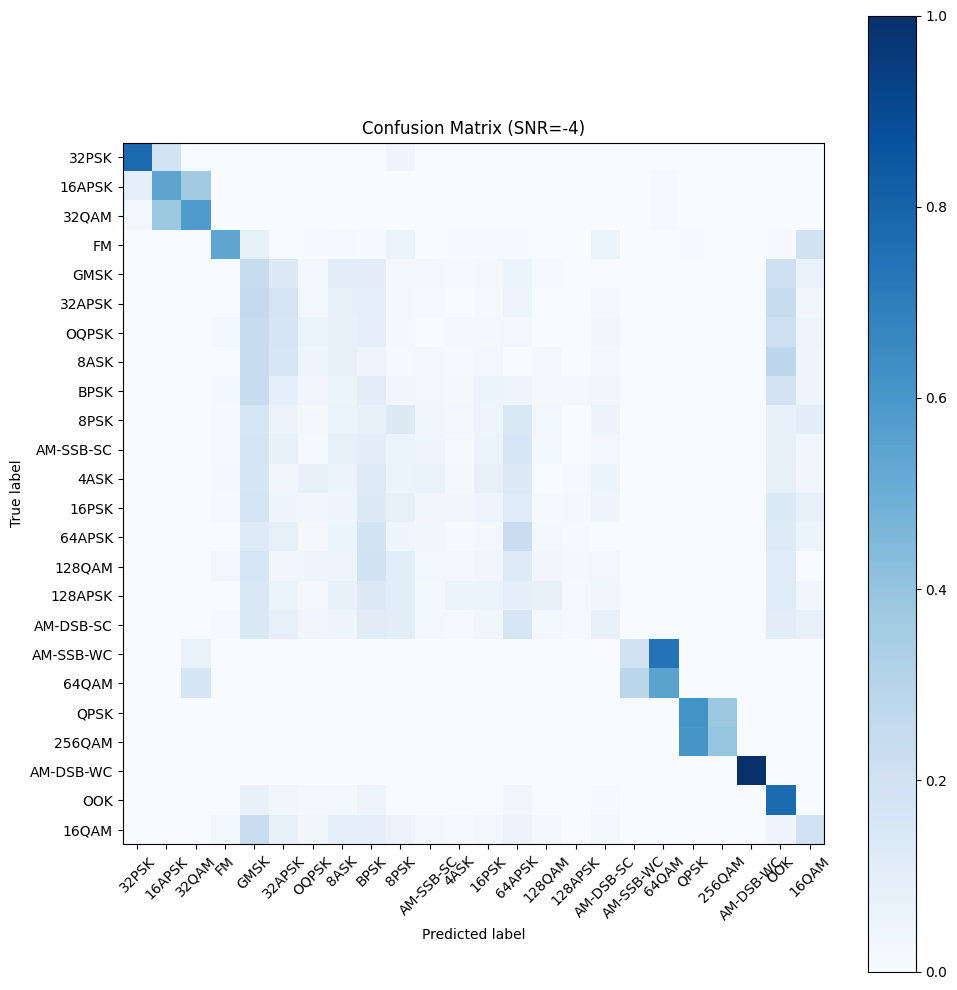

<Figure size 640x480 with 0 Axes>

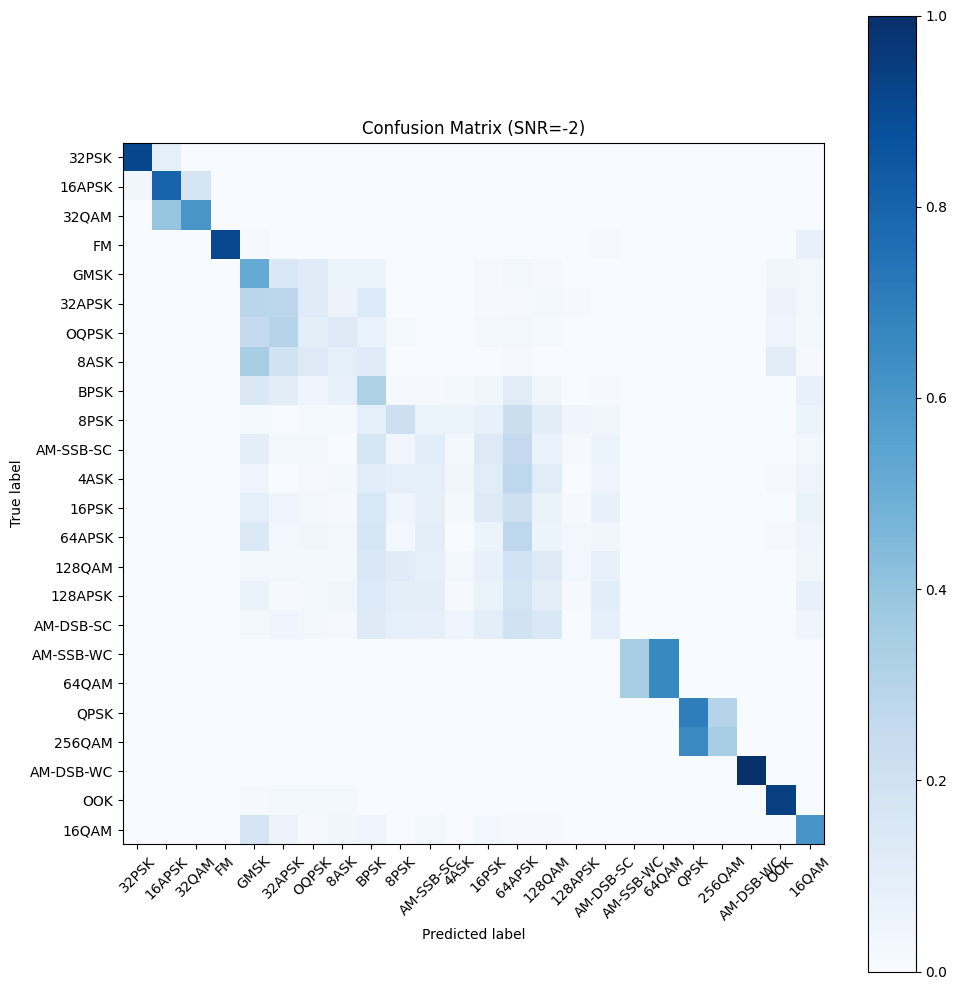

<Figure size 640x480 with 0 Axes>

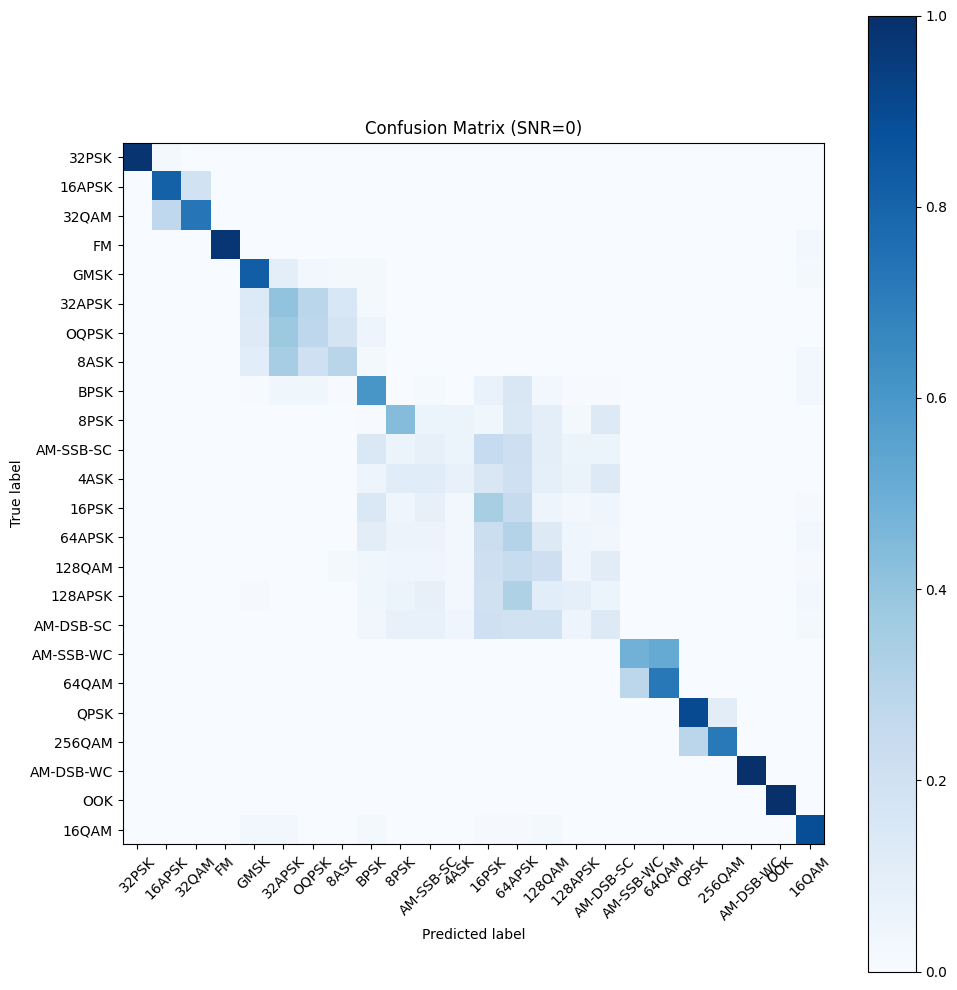

<Figure size 640x480 with 0 Axes>

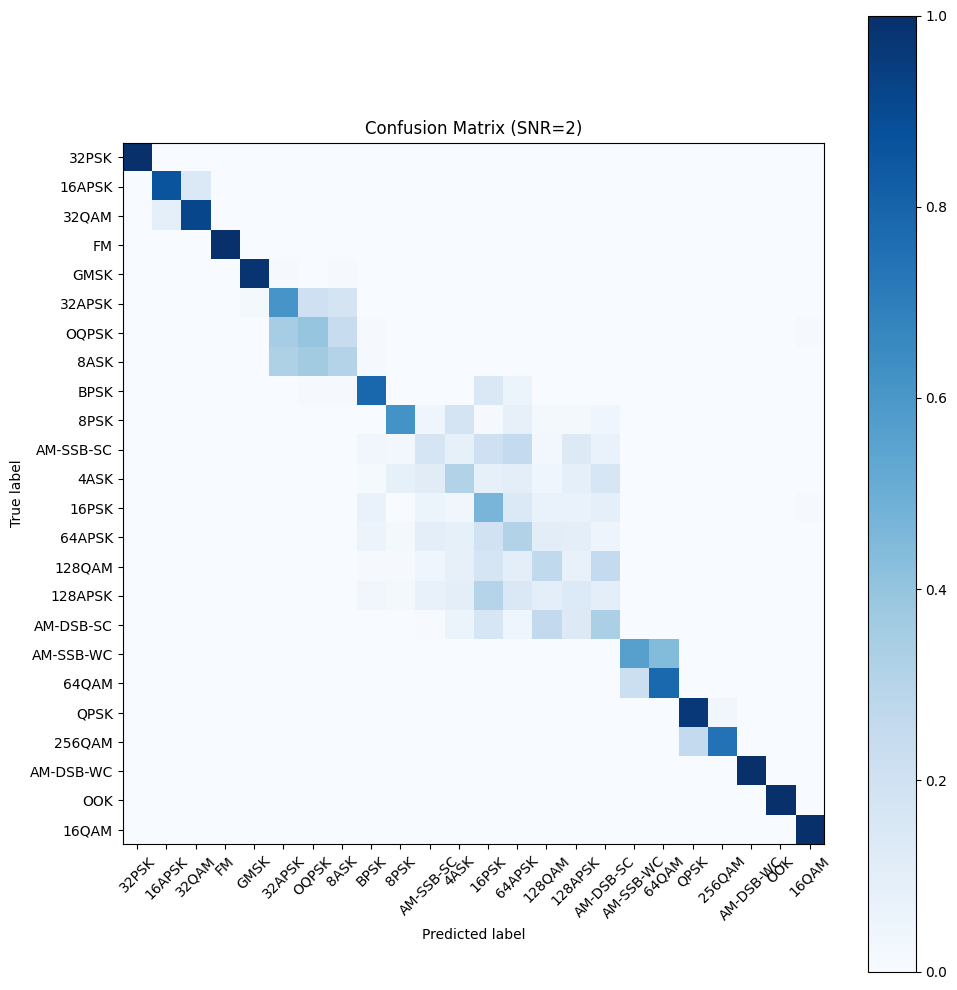

<Figure size 640x480 with 0 Axes>

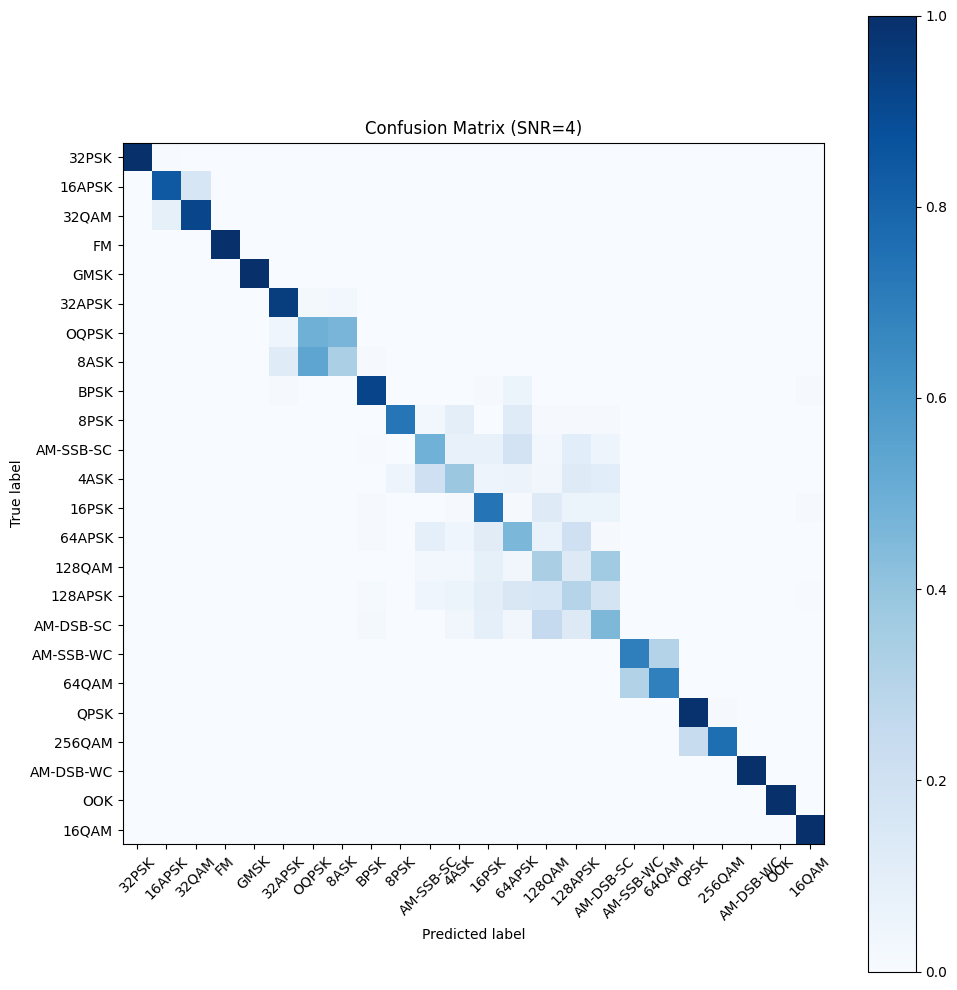

<Figure size 640x480 with 0 Axes>

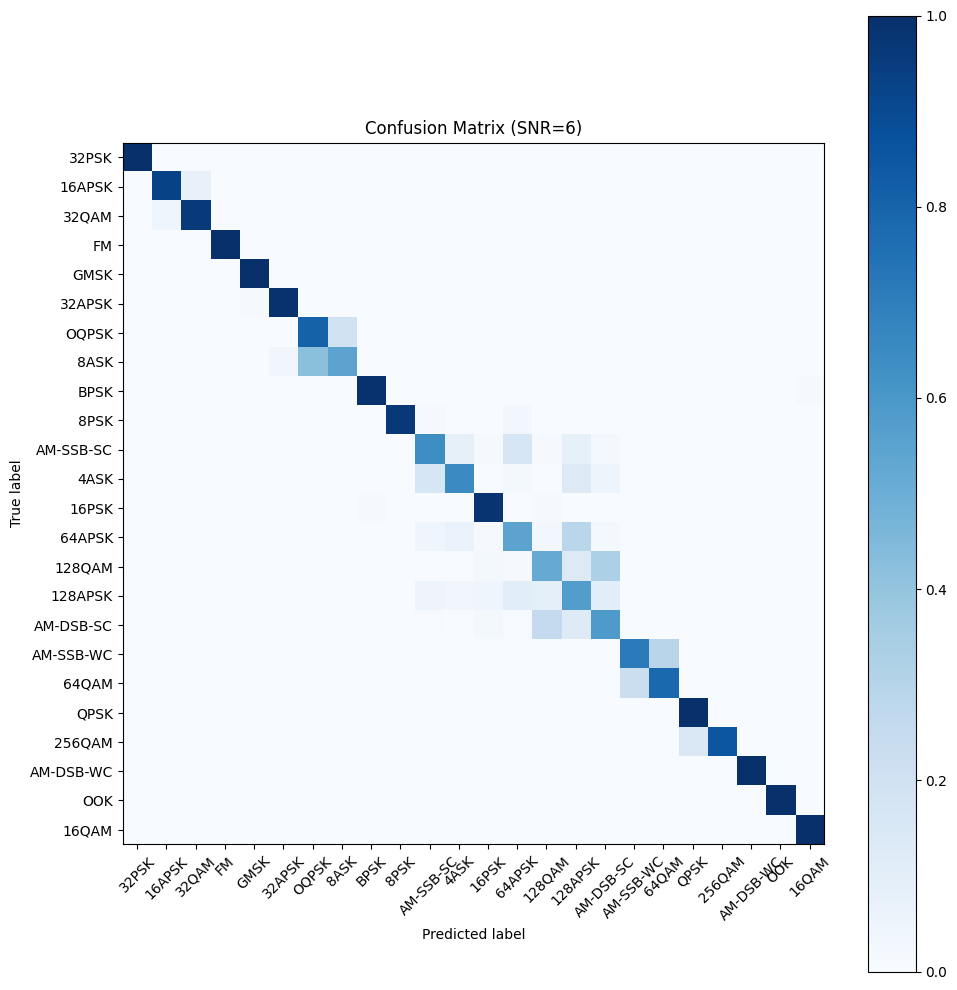

<Figure size 640x480 with 0 Axes>

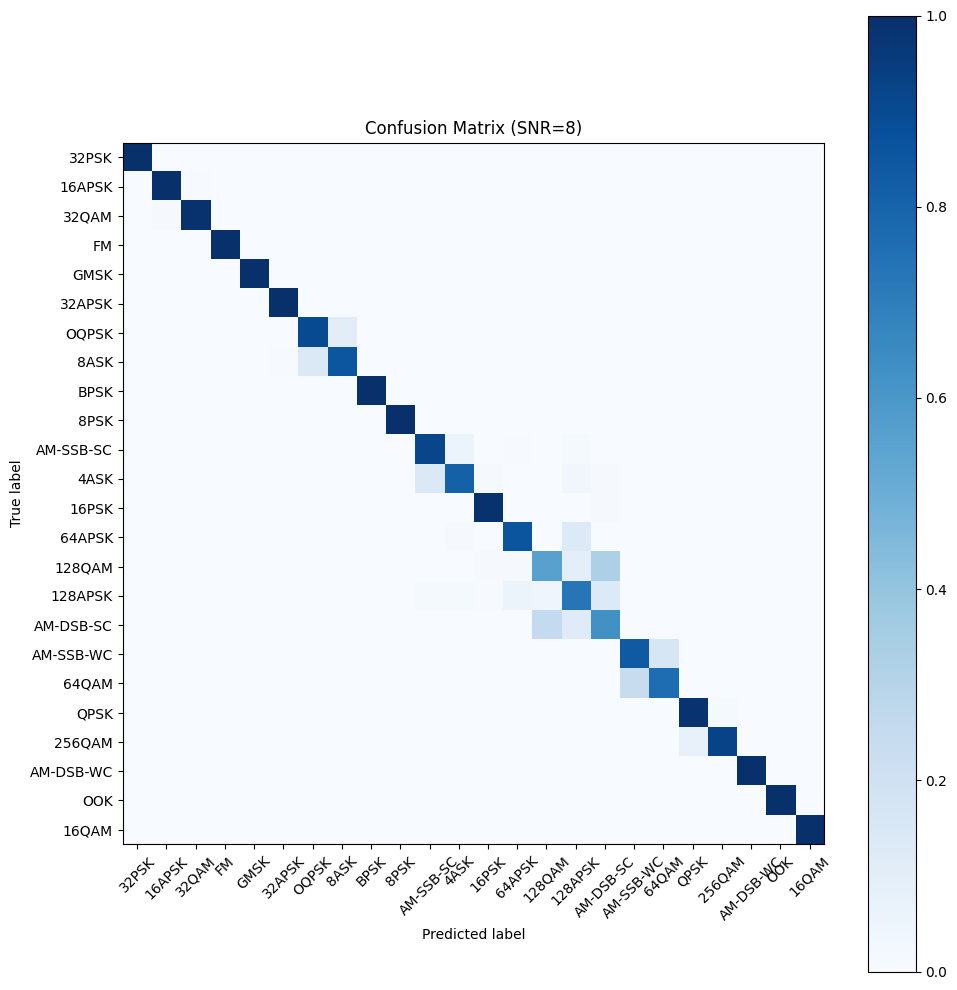

<Figure size 640x480 with 0 Axes>

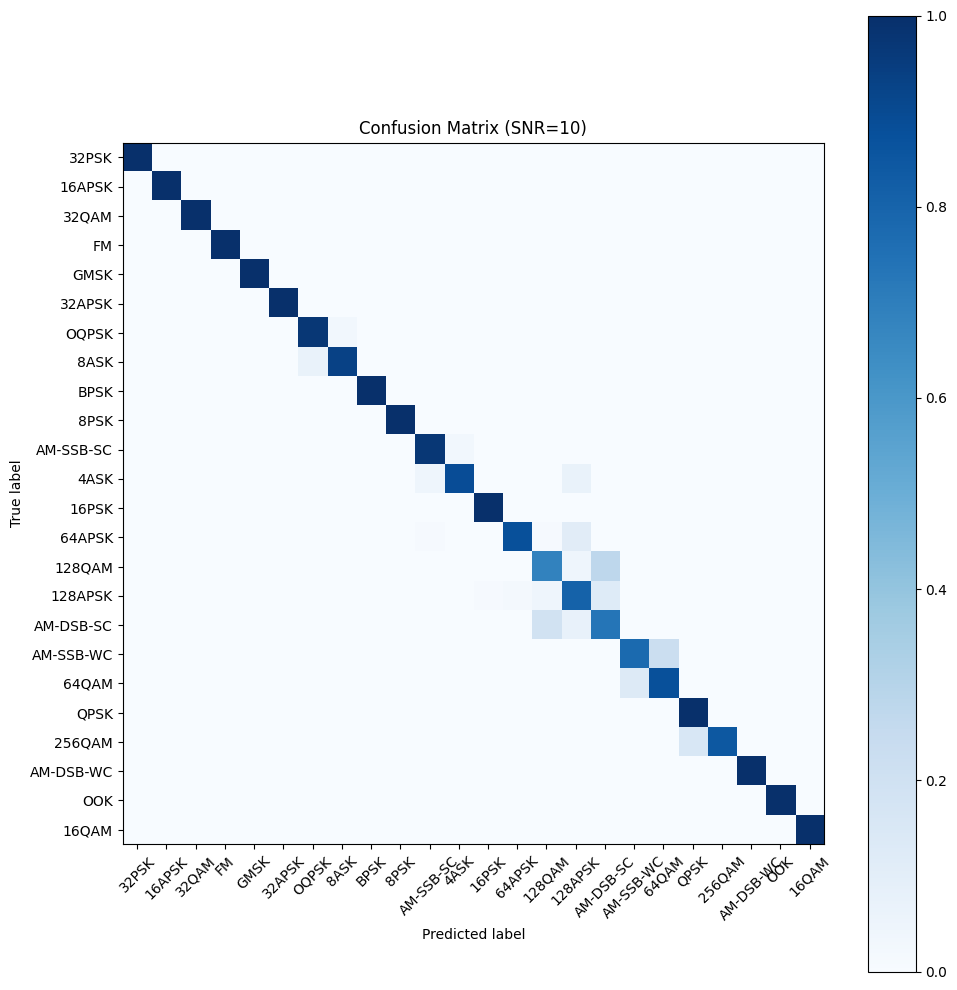

<Figure size 640x480 with 0 Axes>

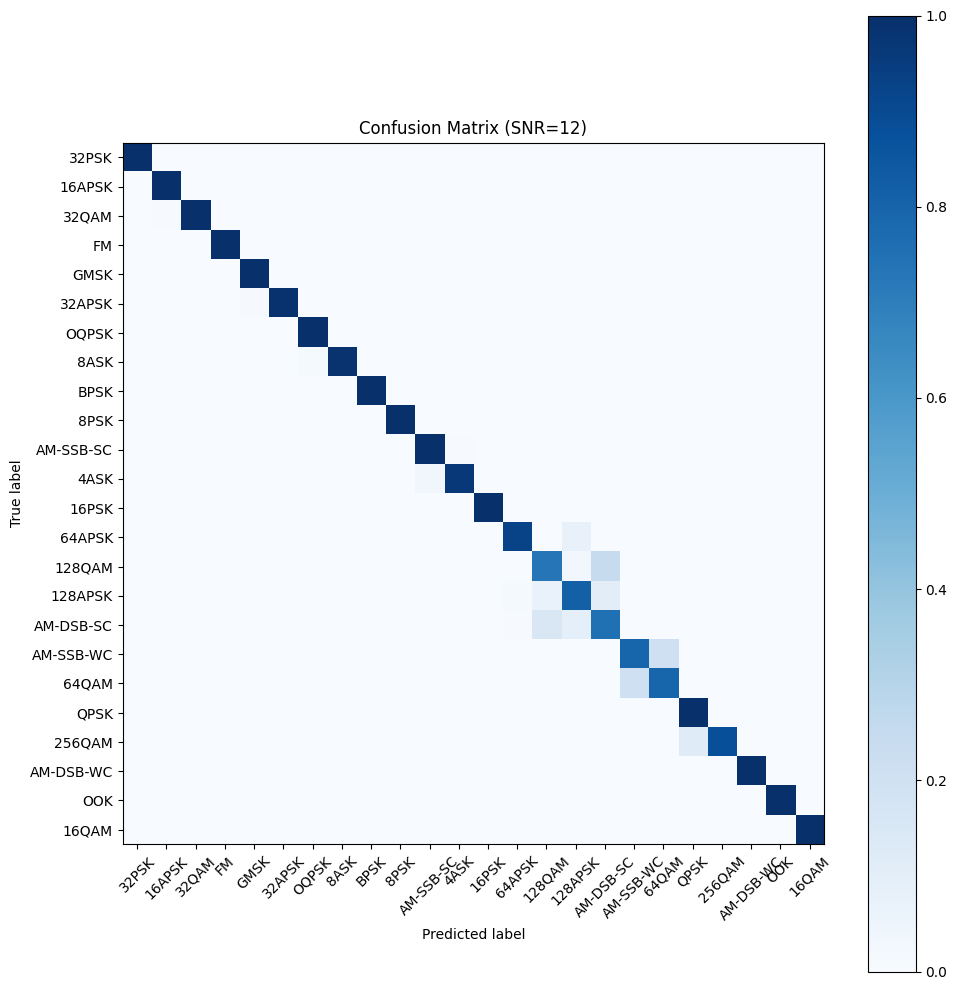

<Figure size 640x480 with 0 Axes>

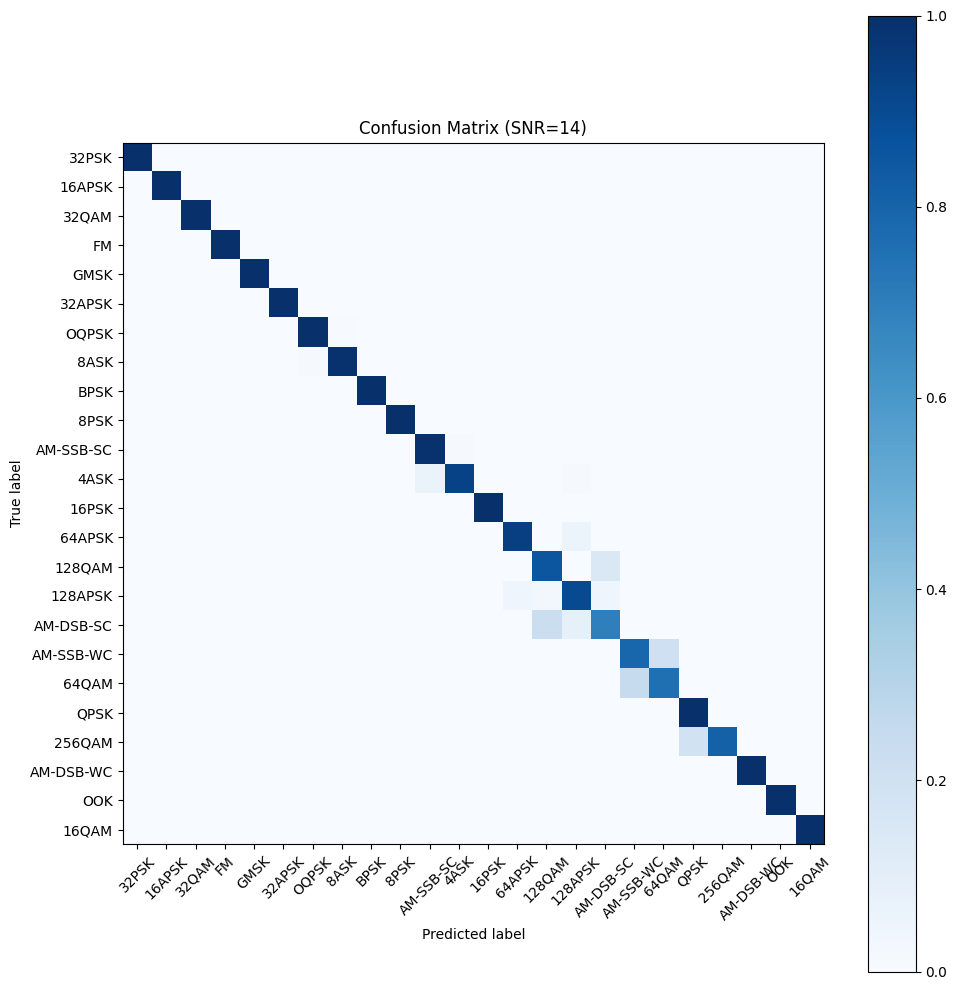

<Figure size 640x480 with 0 Axes>

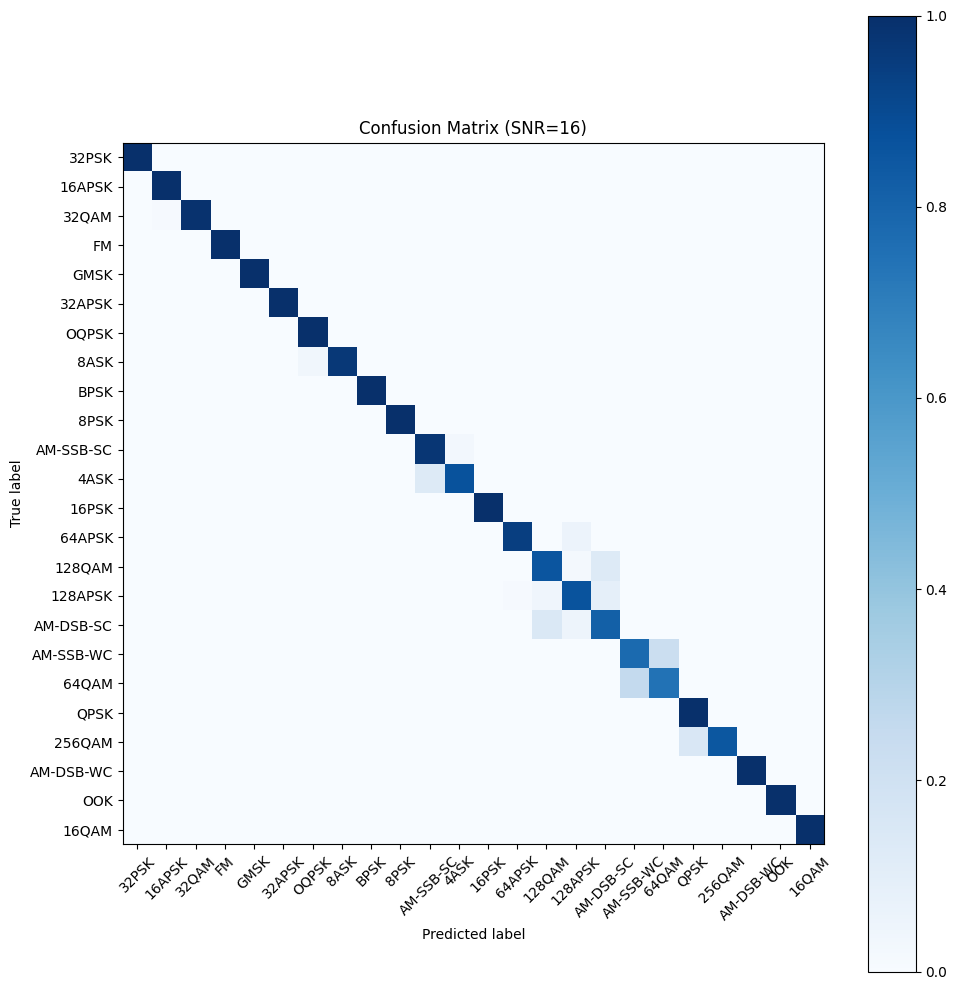

<Figure size 640x480 with 0 Axes>

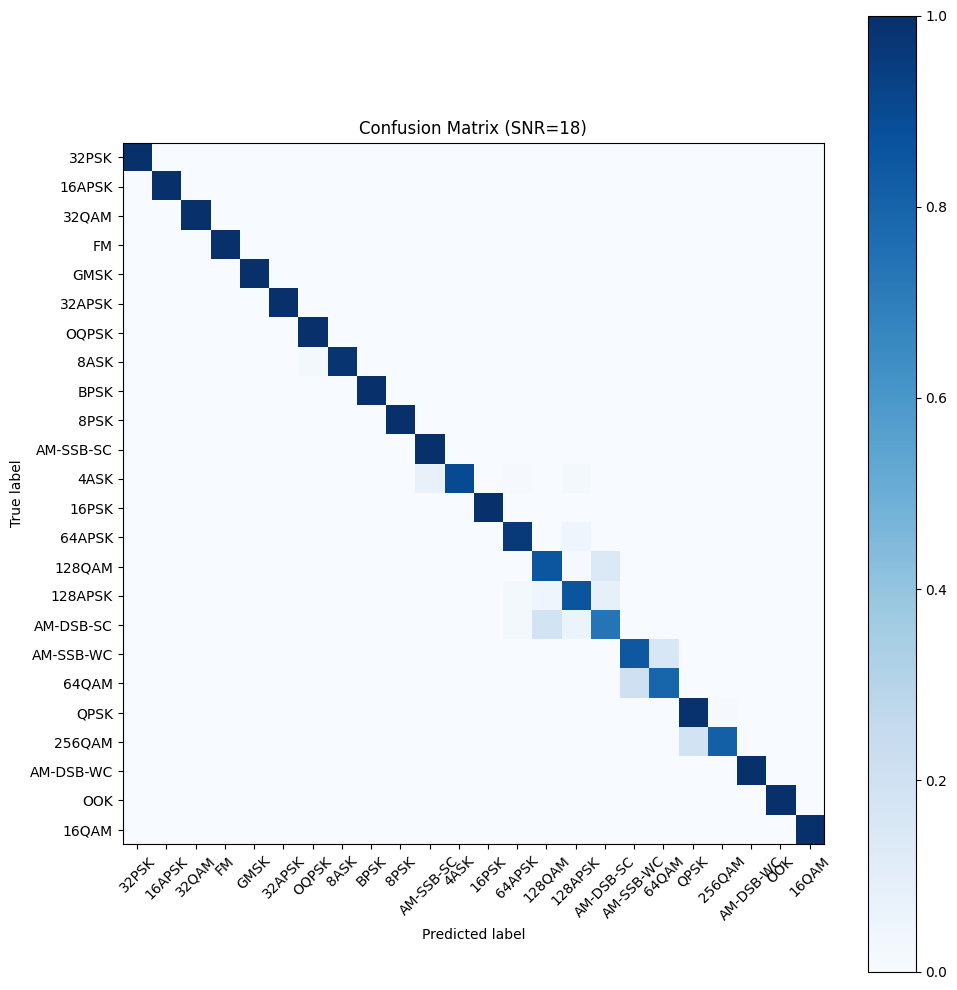

<Figure size 640x480 with 0 Axes>

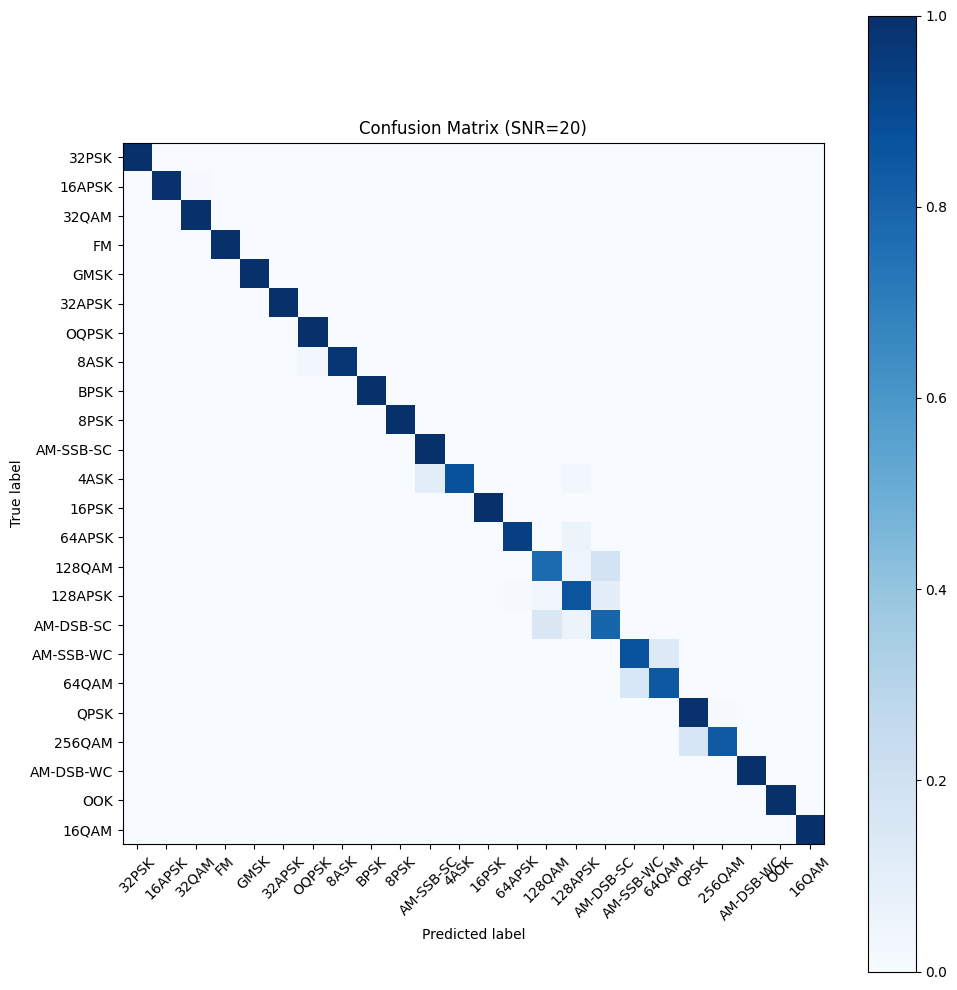

<Figure size 640x480 with 0 Axes>

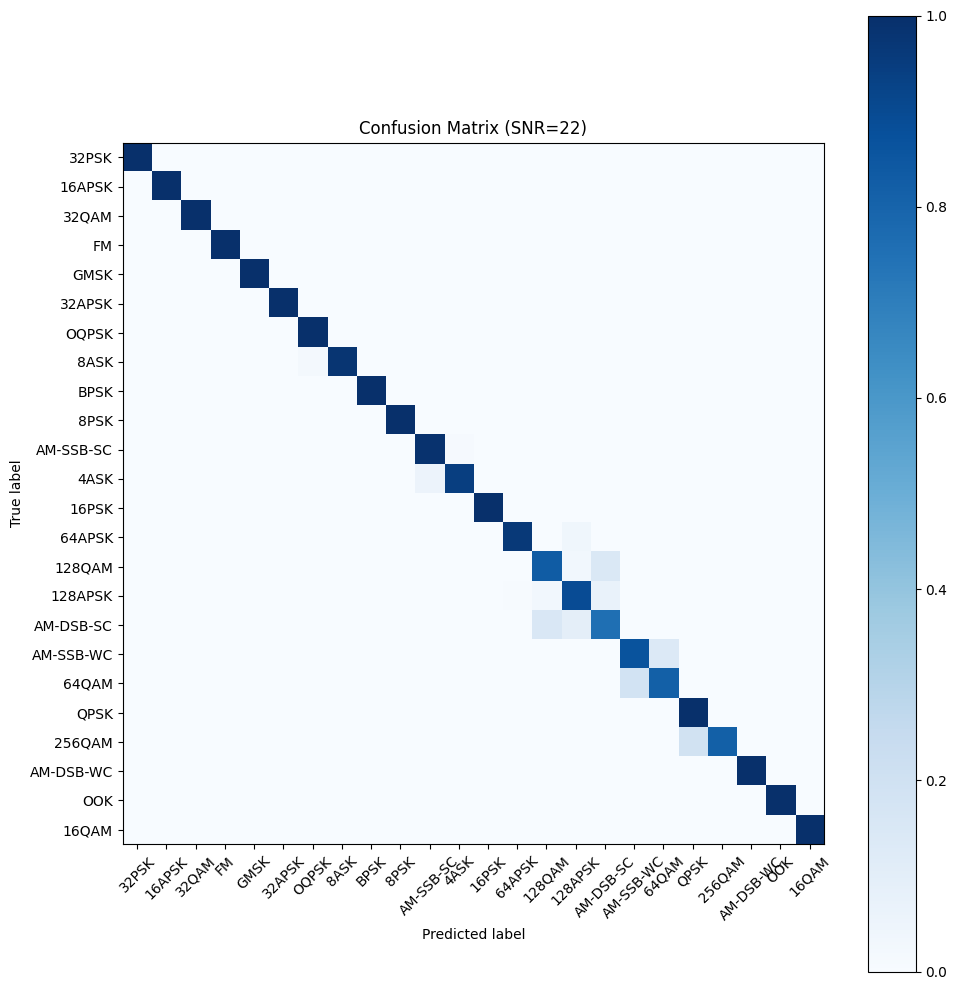

<Figure size 640x480 with 0 Axes>

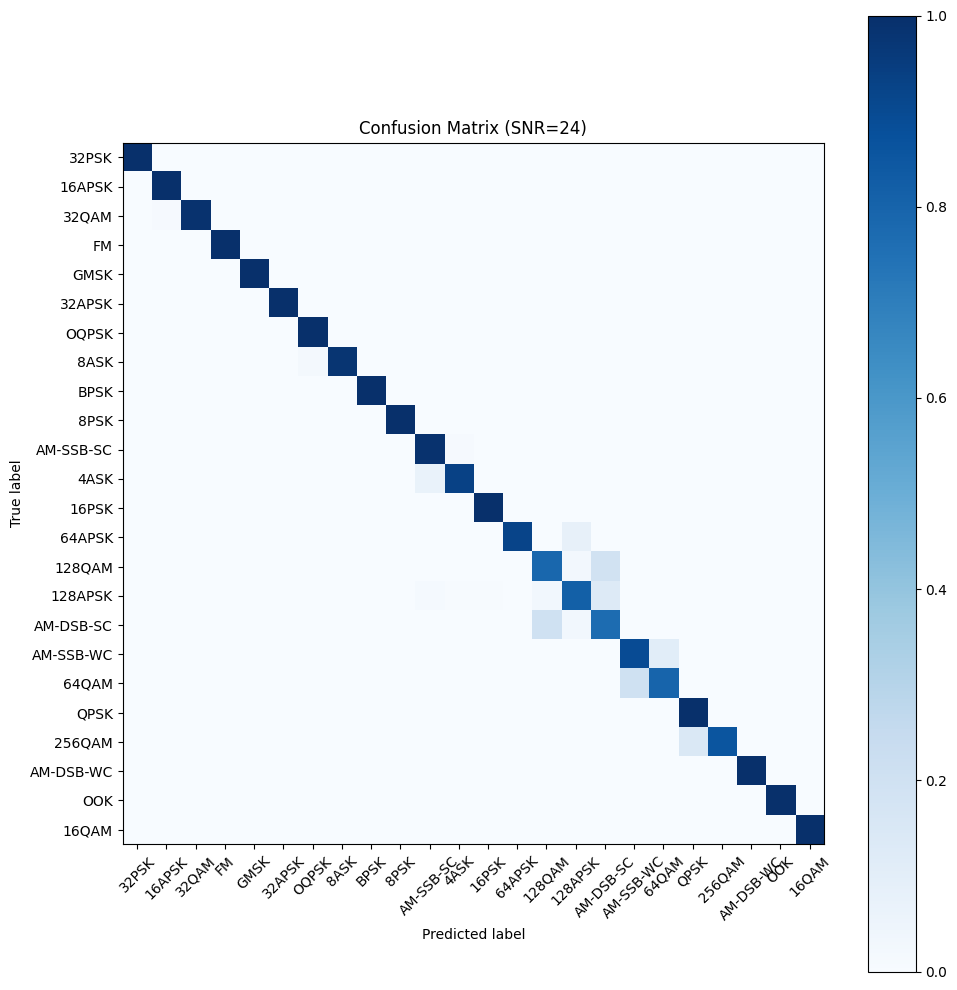

<Figure size 640x480 with 0 Axes>

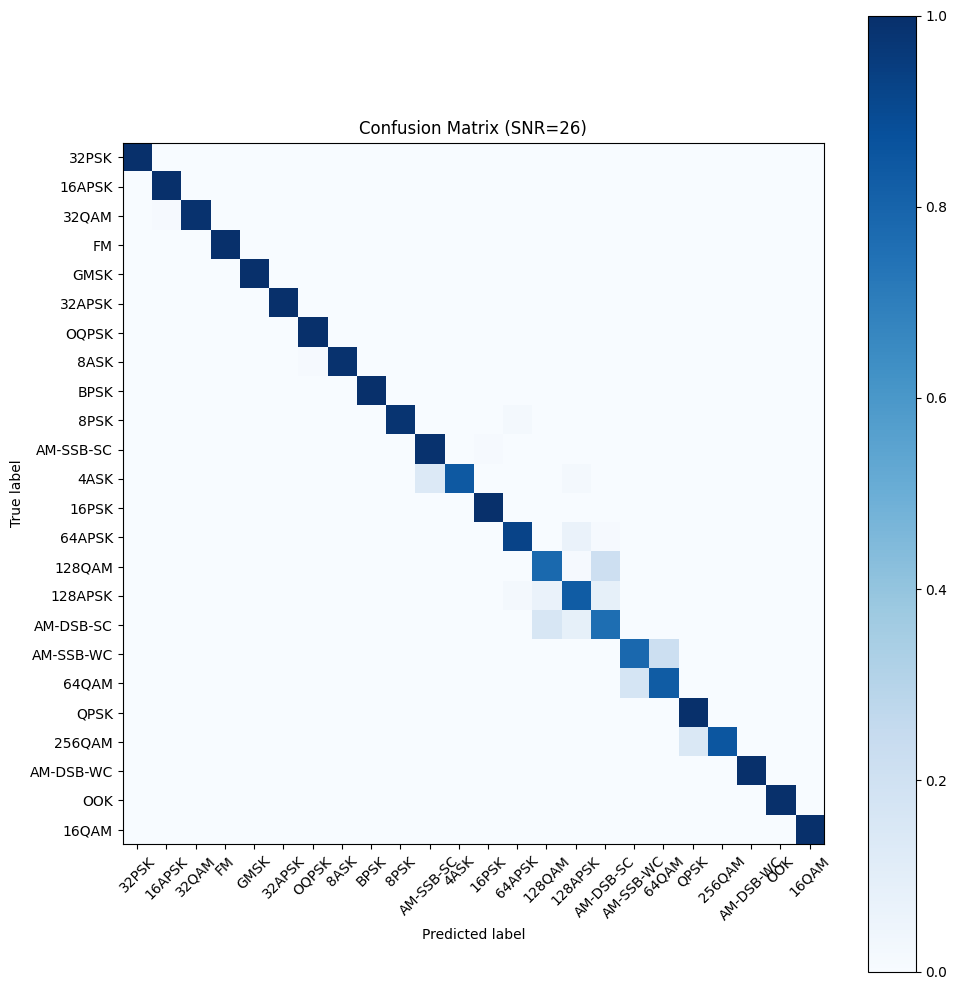

<Figure size 640x480 with 0 Axes>

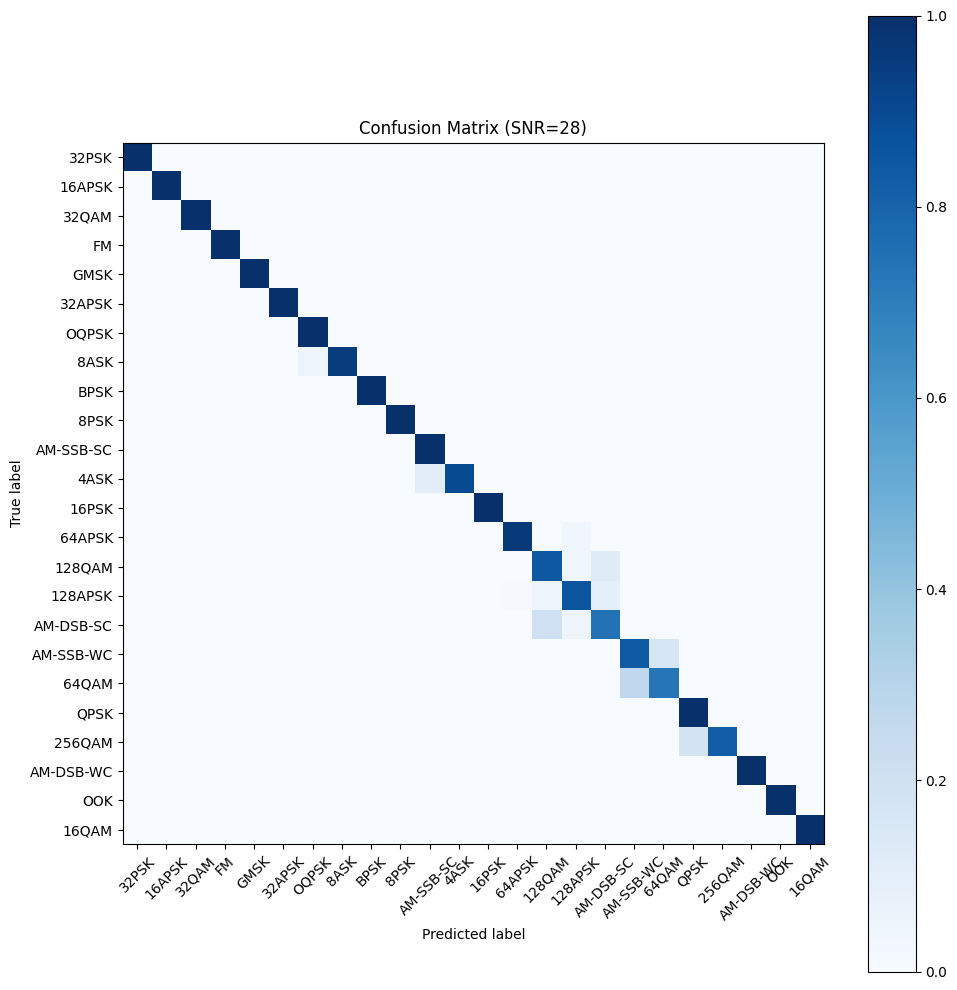

<Figure size 640x480 with 0 Axes>

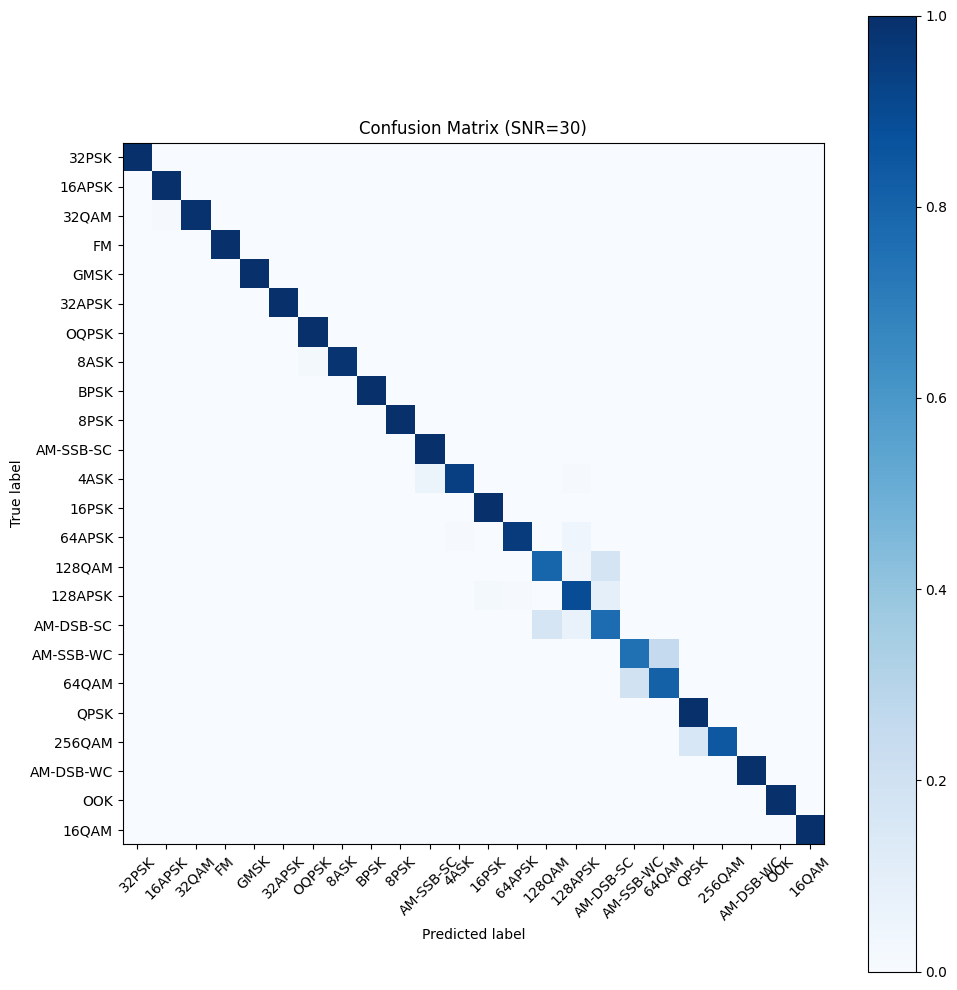

In [9]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    
        j = list(Y_test_snr[i,:]).index(1)  
        k = int(np.argmax(pre_Y_test[i,:])) 
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

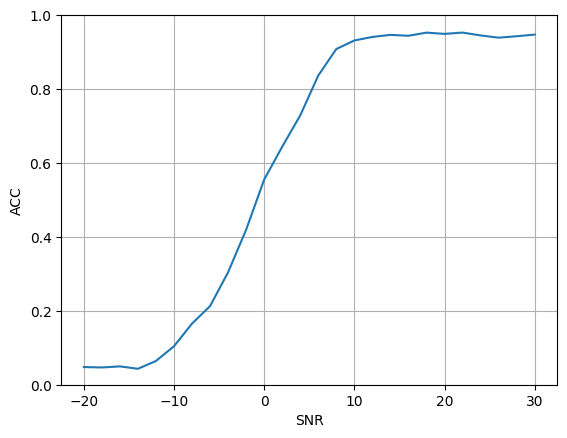

In [10]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.ylim(0, 1)
plt.grid(True)
plt.show()